# Budget Allocation in Online Media Advertising

---

#### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from scipy.optimize import (
    curve_fit,
    minimize,
)

---

#### Data Generation

In [2]:
SPEND = [1_000_000, 1_200_000, 900_000, 950_000, 920_000, 910_000, 980_000, 700_000, 1_300_000]
PERIODS = 24
START_DATE = "2022-01-01"

In [3]:
dates = [pd.to_datetime(START_DATE) + pd.DateOffset(months=i) for i in range(len(SPEND))]

df_spend = pd.DataFrame({
    "investment_id": np.arange(len(SPEND)) + 1,
    "date": dates,
    "spend": SPEND,
})

In [4]:
def data_generation(number_of_periods, y_start, y_end, noise_factor=0.1):
    noise = 1 + ((np.random.random(size=number_of_periods) - 0.5)) * noise_factor
    x = np.arange(number_of_periods)
    k = np.log(y_end / y_start) / (number_of_periods - 1)
    y = y_start * np.exp(k * x)
    return y * noise
    

In [5]:
def data_generation_lag(number_of_periods, y_start, y_end, noise_factor=0.1):
    noise = 1 + ((np.random.random(size=number_of_periods) - 0.5)) * noise_factor
    x = np.arange(number_of_periods)
    k = np.log(y_end / y_start) / (number_of_periods - 1)
    y = y_start * np.exp(k * x)
    y[0], y[3] = y[3], y[0]
    y[1], y[2] = y[2], y[1]
    y[3], y[2] = y[2], y[3] 
    return y * noise

In [6]:
np.random.seed(42)


dfs = []
for i in range(len(SPEND)):
    y_start = 0.3 * (2 - (SPEND[i] / np.mean(SPEND))) ** 0.5
    y_end = 0.02 * (2 - (SPEND[i] / np.mean(SPEND))) ** 0.5

    revenue = SPEND[i] * data_generation(PERIODS, y_start=y_start, y_end=y_end)
    revenue_lag = SPEND[i] * data_generation_lag(PERIODS, y_start=y_start, y_end=y_end)
    df_investment = pd.DataFrame({
        "date": pd.date_range(dates[i], periods=PERIODS, freq="MS"),
        "period": np.arange(PERIODS) + 1,
        "revenue": revenue,
        "revenue_lag": revenue_lag,
        "investment_id": i + 1,
    }).astype({"revenue": int})
    dfs.append(df_investment)

df = pd.concat(dfs)

In [7]:
df = df.merge(df_spend.drop("date", axis=1), on="investment_id", how="left")

---

#### Data Preprocessing

In [8]:
# Normalise the data

df["roas"] = df["revenue_lag"] / df["spend"]

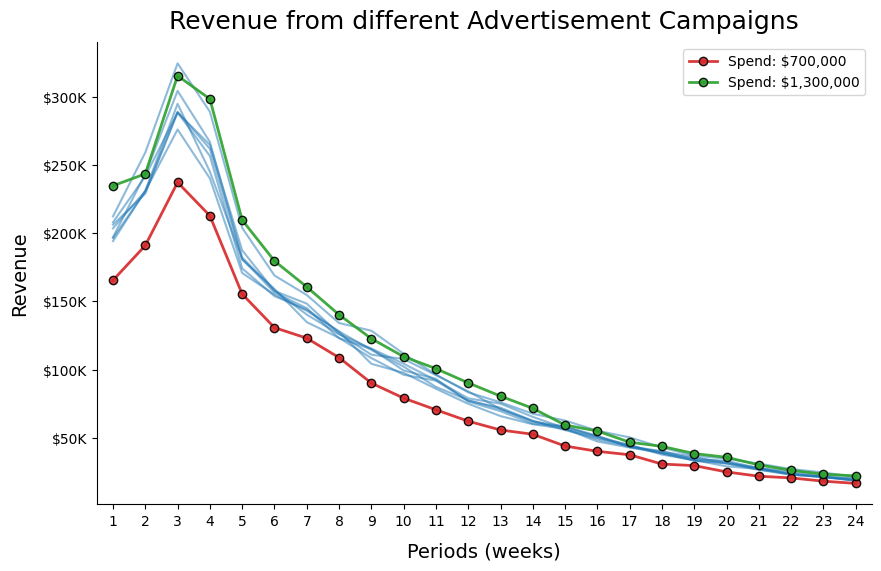

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

for investment_id, data in df.groupby("investment_id"):
    plot_kwargs = {"color": "tab:blue", "alpha": 0.5}
    if investment_id == 8:
        plot_kwargs = {
            "color": "tab:red",
            "alpha": 0.9,
            "marker": "o",
            "markeredgecolor": "black",
            "lw": 2,
            "label": f"Spend: ${SPEND[investment_id - 1]:,}",
            }
    elif investment_id == 9:
        plot_kwargs = {
            "color": "tab:green",
            "alpha": 0.9,
            "markeredgecolor": "black",
            "marker": "o",
            "lw": 2,
            "label": f"Spend: ${SPEND[investment_id - 1]:,}",
            }
    
    ax.plot(data["period"], data["revenue_lag"], **plot_kwargs)

ax.legend()
ax.set_title("Revenue from different Advertisement Campaigns", pad=10, fontsize=18)
ax.set_xlabel("Periods (weeks)", fontsize=14, labelpad=10)
ax.set_ylabel("Revenue", fontsize=14, labelpad=10)
ax.set_xlim(0.5, PERIODS + 0.5)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"${x / 1_000:.0f}K"))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.savefig("data_revenue.png", dpi=300, bbox_inches="tight")

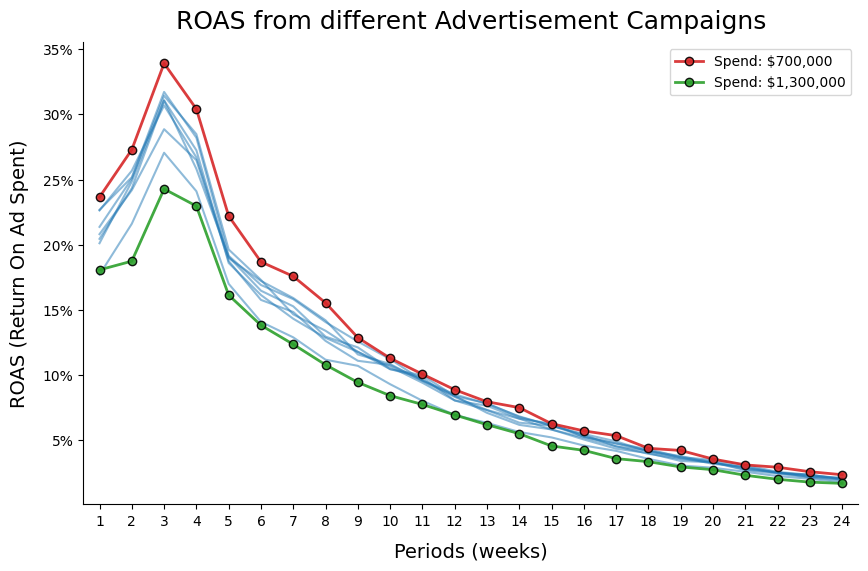

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

for investment_id, data in df.groupby("investment_id"):
    
    plot_kwargs = {"color": "tab:blue", "alpha": 0.5}
    if investment_id == 8:
        plot_kwargs = {
            "color": "tab:red",
            "alpha": 0.9,
            "marker": "o",
            "markeredgecolor": "black",
            "lw": 2,
            "label": f"Spend: ${SPEND[investment_id - 1]:,}",
            }
    elif investment_id == 9:
        plot_kwargs = {
            "color": "tab:green",
            "alpha": 0.9,
            "markeredgecolor": "black",
            "marker": "o",
            "lw": 2,
            "label": f"Spend: ${SPEND[investment_id - 1]:,}",
            }
    
    ax.plot(data["period"], data["roas"], **plot_kwargs)
    
ax.legend()
ax.set_title("ROAS from different Advertisement Campaigns", pad=10, fontsize=18)
ax.set_xlabel("Periods (weeks)", fontsize=14, labelpad=10)
ax.set_ylabel("ROAS (Return On Ad Spent)", fontsize=14, labelpad=10)
ax.set_xlim(0.5, PERIODS + 0.5)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.savefig("data_roas.png", dpi=300, bbox_inches="tight")

---

### Modeling

In [11]:
COL = "revenue_lag"

#### Hill Model

In [12]:
data = df[df["period"] == 1]

x = data["spend"].to_numpy()
y = data[COL].to_numpy()

In [13]:
def hill(s, alpha, beta):
    """
    Hill function: 1 - alpha / (s + alpha)
    B * Hill function: (1 - alpha / (s + alpha)) * beta
    """
    return beta - (alpha * beta) / (s + alpha)



popt_hill, pcov = curve_fit(hill, x, y, maxfev=1000)

In [14]:
x_grid = np.arange(0, 10_000_000, 50_000)
y_pred = hill(x_grid, *popt_hill)

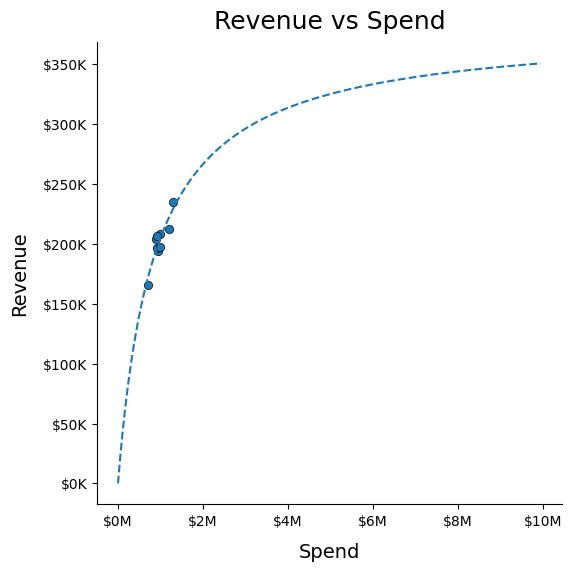

In [15]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.scatterplot(x=x, y=y, edgecolor="k", ax=ax)
ax.plot(x_grid, y_pred, color="tab:blue", ls="--")

ax.set_title("Revenue vs Spend", pad=10, fontsize=18)
ax.set_xlabel("Spend", fontsize=14, labelpad=10)
ax.set_ylabel("Revenue", fontsize=14, labelpad=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"${x / 1_000:.0f}K"))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"${x / 1_000_000:.0f}M"))

fig.savefig("revenue_vs_spend.png", dpi=300, bbox_inches="tight")


---

#### Geometric Decay Model

In [16]:
from scipy.stats import (
    gamma,
    chi2,
)


def multipliers(x, a, b, c, d, e, f, h, g):
    """
    Linear combination of gamma and chi2 distributions can be used to model
    exponential decay and also to model the lag effect if exisits
    """
    return a * gamma.pdf(x, b) + c * gamma.pdf(x, d) + e * chi2.pdf(x, f) + h * chi2.pdf(x, g)

In [17]:
x = df["period"]
y = df[COL] / df.groupby("investment_id")[COL].transform("first")

popt_multipliers, cov = curve_fit(
    f=multipliers,
    xdata=x,
    ydata=y,
    maxfev=10000,
)

In [18]:
x_grid = np.arange(24) + 1
y_pred = multipliers(x_grid, *popt_multipliers)

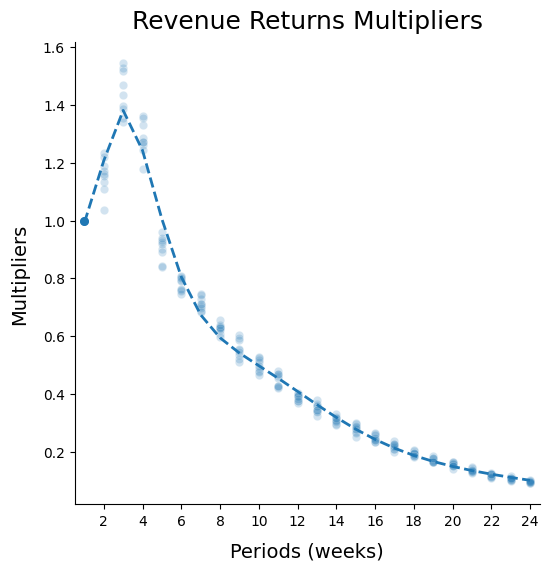

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.scatterplot(data=df, x="period", y=y, color="tab:blue", alpha=0.2)
ax.scatter(1, 1, color="tab:blue", s=30)
ax.plot(x_grid, y_pred, color="tab:blue", ls="--", lw=2)

ax.set_title("Revenue Returns Multipliers", pad=10, fontsize=18)
ax.set_xlim(0.5, PERIODS + 0.5)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.set_xlabel("Periods (weeks)", fontsize=14, labelpad=10)
ax.set_ylabel("Multipliers", fontsize=14, labelpad=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.savefig("revenue_multipliers.png", dpi=300, bbox_inches="tight")


---

### Analysis

In [20]:
def expected_revenue(s, P):
    base_revenue = hill(s, *popt_hill)
    returns_factors = multipliers(P, *popt_multipliers)
    return base_revenue * returns_factors

In [21]:
N_PERIODS = 24
s = SPEND[0]
P = np.arange(N_PERIODS) + 1

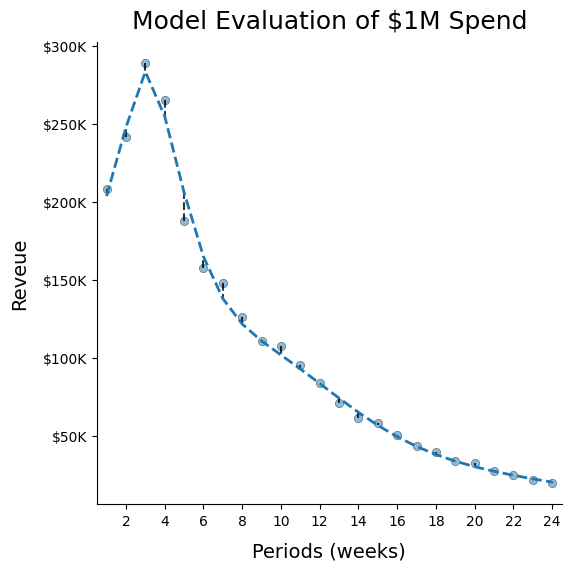

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))

y = df[df["investment_id"] == 1]["revenue_lag"]
y_pred = expected_revenue(s=s, P=P)

ax.vlines(P, y, y_pred, color="k", ls="--", lw=1.5, alpha=0.8)
sns.scatterplot(data=df[df["investment_id"] == 1], x="period", y="revenue_lag", alpha=0.5, edgecolor="k")
ax.plot(P, y_pred, color="tab:blue", ls="--", lw=2)

ax.set_title("Model Evaluation of $1M Spend", pad=10, fontsize=18)
ax.set_xlim(0.5, PERIODS + 0.5)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.set_xlabel("Periods (weeks)", fontsize=14, labelpad=10)
ax.set_ylabel("Reveue", fontsize=14, labelpad=10)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"${x / 1_000:.0f}K"))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.savefig("model_evaluation.png", dpi=300, bbox_inches="tight")


In [23]:
N_PERIODS = 24
spends = [100_000, 500_000, 1_000_000, 2_000_000, 3_000_000, 4_000_000, 5_000_000]
P = np.arange(N_PERIODS) + 1

palette = sns.color_palette("Blues", n_colors=len(spends))

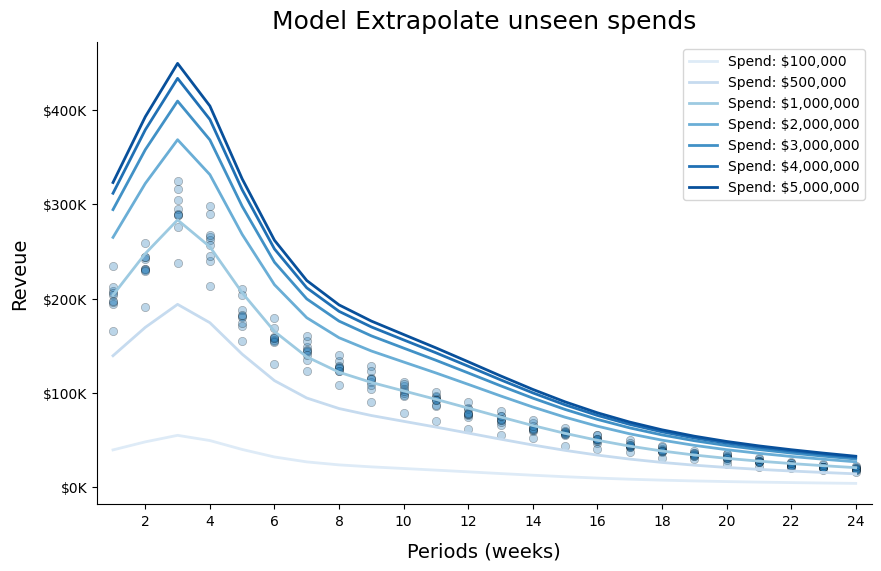

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(data=df, x="period", y="revenue_lag", color="tab:blue", edgecolor="k", alpha=0.3, legend=False)
for i, spend in enumerate(spends):
    ax.plot(np.arange(N_PERIODS) + 1, expected_revenue(s=spend, P=P), lw=2, color=palette[i], label=f"Spend: ${spend:,}")

ax.legend()
ax.set_title("Model Extrapolate unseen spends", pad=10, fontsize=18)
ax.set_xlim(0.5, PERIODS + 0.5)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.set_xlabel("Periods (weeks)", fontsize=14, labelpad=10)
ax.set_ylabel("Reveue", fontsize=14, labelpad=10)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"${x / 1_000:.0f}K"))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.savefig("model_extrapolate_spend.png", dpi=300, bbox_inches="tight")

In [25]:
N_PERIODS = 48
spends = [1_000_000]
P = np.arange(N_PERIODS) + 1

palette = sns.color_palette("Blues", n_colors=len(spends))

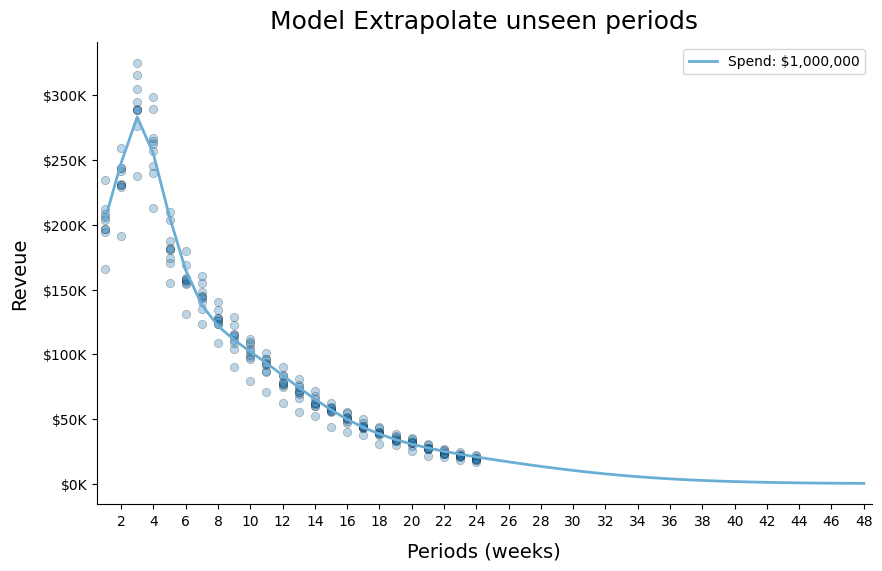

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(data=df, x="period", y="revenue_lag", color="tab:blue", edgecolor="k", alpha=0.3, legend=False)
for i, spend in enumerate(spends):
    ax.plot(np.arange(N_PERIODS) + 1, expected_revenue(s=spend, P=P), lw=2, color=palette[i], label=f"Spend: ${spend:,}")

ax.legend()
ax.set_title("Model Extrapolate unseen periods", pad=10, fontsize=18)
ax.set_xlim(0.5, N_PERIODS + 0.5)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.set_xlabel("Periods (weeks)", fontsize=14, labelpad=10)
ax.set_ylabel("Reveue", fontsize=14, labelpad=10)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"${x / 1_000:.0f}K"))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.savefig("model_extrapolate_periods.png", dpi=300, bbox_inches="tight")

In [27]:
N_PERIODS = 24
spends = [100_000, 500_000, 1_000_000, 2_000_000, 3_000_000, 4_000_000, 5_000_000]
P = np.arange(N_PERIODS) + 1

palette = sns.color_palette("Blues", n_colors=len(spends))

In [28]:
N_PERIODS = 24
spends = np.arange(0, 3_000_000, 100_000)[::-1]
P = np.arange(N_PERIODS) + 1

palette = sns.color_palette("coolwarm", n_colors=len(spends))


opt_dfs = []
for i, s in enumerate(spends):
    opt_df = pd.DataFrame({
        "n_periods": P,
        "profit": expected_revenue(s=s, P=P).cumsum() - s,
        "spend": [s] * N_PERIODS,
    })
    opt_dfs.append(opt_df)

opt_df = pd.concat(opt_dfs)

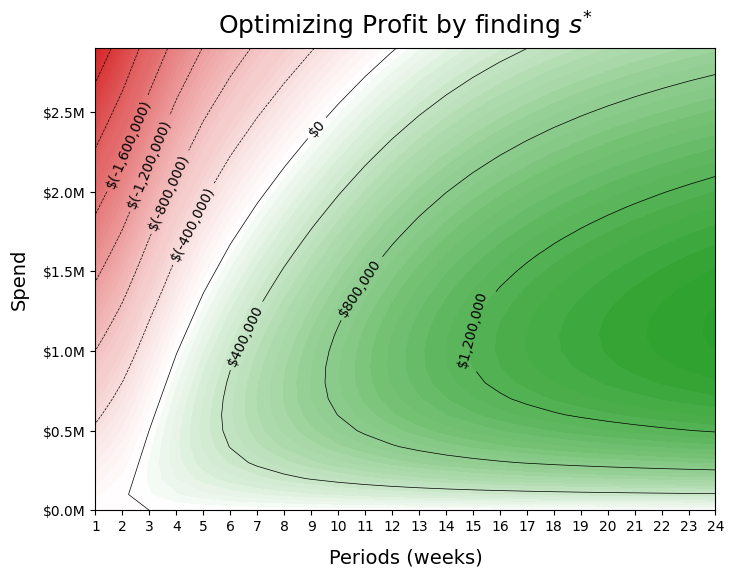

In [29]:
from matplotlib.colors import (
    LinearSegmentedColormap,
    TwoSlopeNorm,
)


colors = [plt.cm.tab10(3), (1, 1, 1), plt.cm.tab10(2)]
n_bins = 100  # Discretizes the interpolation into bins
custom_cmap = LinearSegmentedColormap.from_list("cmap", colors, N=n_bins)

pivot_table = opt_df.pivot(index="spend", columns="n_periods", values="profit")

X = pivot_table.columns.values
Y = pivot_table.index.values
X, Y = np.meshgrid(X, Y)
Z = pivot_table.values

fig, ax = plt.subplots(figsize=(8, 6))

norm = TwoSlopeNorm(vmin=Z.min(), vcenter=0, vmax=Z.max())
contour_filled = ax.contourf(X, Y, Z, levels=100, cmap=custom_cmap, norm=norm)
contour_lines = ax.contour(X, Y, Z, levels=10, colors="black", linewidths=0.5)
ax.clabel(contour_lines, inline=True, fmt=lambda x: f"$({x:,.0f})" if x < 0 else f"${x:,.0f}", fontsize=10)

ax.set_title("Optimizing Profit by finding " + r"$s^{*}$", pad=10, fontsize=18)
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_xlabel("Periods (weeks)", fontsize=14, labelpad=10)
ax.set_ylabel("Spend", fontsize=14, labelpad=10)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"${x / 1_000_000:.1f}M"))

fig.savefig("optimization_contours.png", dpi=300, bbox_inches="tight")


---

### Optimization

In [30]:
def objective(s):

    # income
    income = expected_revenue(s=s, P=P).sum()

    # interest rate / depreciation
    interest_rate = 0.05
    income_after_interest = income * (1 - interest_rate)

    # net income
    fees = 0.03
    net_income = (income_after_interest * (1 - fees)) - s
    
    return -net_income

In [31]:
# optimisation
N_PERIODS = 24
budget_lower = 0
budget_upper = 2_000_000

P = np.arange(N_PERIODS) + 1

result = minimize(
    objective,
    x0=np.array(SPEND).mean(),
    bounds=[(budget_lower, budget_upper)],
    method="Nelder-Mead",
    tol=0.01,
)

In [32]:
optimal_spend = result.x[0]
profit = -result.fun

print(f"Optimal spend: {optimal_spend:,.0f}")
print(f"Profit: {profit:,.0f}")

Optimal spend: 1,058,409
Profit: 1,305,969


---